In [1]:
import json

with open('train-test-rumi-to-jawi.json') as fopen:
    dataset = json.load(fopen)
len(dataset['train']), len(dataset['test'])

(24840, 6211)

In [2]:
with open('train-test-wiki.json') as fopen:
    dataset_wiki = json.load(fopen)

In [3]:
dataset['train'] = dataset['train'] + dataset_wiki['train']
dataset['test'] = dataset['test'] + dataset_wiki['test']
len(dataset['train']), len(dataset['test'])

(64840, 16211)

In [4]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize as imresize
import cv2

/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/husein/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: 

In [5]:
train_labels = [f.split('/')[1].split('.')[0].lower() for f in dataset['train']]
test_labels = [f.split('/')[1].split('.')[0].lower() for f in dataset['test']]

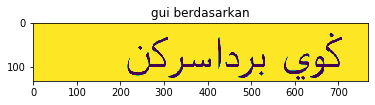

In [6]:
plt.imshow(cv2.imread(dataset['train'][-1], 0).astype(np.float32)/255.)
plt.title(train_labels[-1])
plt.show()

In [7]:
image_height = 60
image_width = 240
image_channel = 1
max_stepsize = 128
num_hidden = 256
epoch = 20
batch_size = 128
initial_learning_rate = 1e-3

In [8]:
from scipy.ndimage.interpolation import map_coordinates
from scipy.ndimage.filters import gaussian_filter

def elastic_transform(image, alpha, sigma, alpha_affine, random_state=None):
    if random_state is None:
        random_state = np.random.RandomState(None)

    shape = image.shape
    shape_size = shape[:2]
    
    blur_size = int(4*sigma) | 1
    dx = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)
    dy = alpha * cv2.GaussianBlur((random_state.rand(*shape) * 2 - 1),
                                  ksize=(blur_size, blur_size),
                                  sigmaX=sigma)

    x, y = np.meshgrid(np.arange(shape[1]), np.arange(shape[0]))
    indices = np.reshape(y+dy, (-1, 1)), np.reshape(x+dx, (-1, 1))

    image =  map_coordinates(image, indices, order=1, mode='constant').reshape(shape)
    
    # Random affine
    center_square = np.float32(shape_size) // 2
    square_size = min(shape_size) // 4
    pts1 = np.float32([center_square + square_size,
                       [center_square[0]+square_size, 
                        center_square[1]-square_size],
                       center_square - square_size])
    pts2 = pts1 + random_state.uniform(-alpha_affine, alpha_affine, size=pts1.shape).astype(np.float32)
    M = cv2.getAffineTransform(pts1, pts2)
    image = cv2.warpAffine(image, M, shape_size[::-1], borderMode=cv2.BORDER_CONSTANT)

    return image

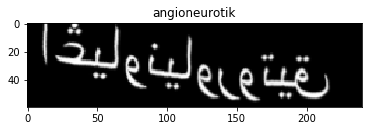

CPU times: user 363 ms, sys: 115 ms, total: 478 ms
Wall time: 232 ms


In [9]:
%%time

img = cv2.imread(dataset['train'][3], 0)
img = cv2.bitwise_not(img)
img = img[:, np.min(np.where(img > 0)[1]) - 50:]
im = imresize(cv2.flip((img.astype(np.float32)/255.), 1), (image_height,
                                                           image_width,
                                                           image_channel))[:,:,0]
im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.3, im.shape[1] * 0.0001)
plt.imshow(im, cmap = 'gray')
plt.title(train_labels[3])
plt.show()

In [10]:
import tqdm
train_X = []
for img in tqdm.tqdm(dataset['train']):
    img = cv2.imread(img, 0)
    img = cv2.bitwise_not(img)
    img = img[:, np.min(np.where(img > 0)[1]) - 50:]
    im = imresize(cv2.flip((img.astype(np.float32)/255.), 1), (image_height,
                                                           image_width,
                                                           image_channel))[:,:,0]
    im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.3, im.shape[1] * 0.0001)
    train_X.append(im)

100%|██████████| 64840/64840 [15:17<00:00, 70.64it/s]


In [12]:
test_X = []
for img in tqdm.tqdm(dataset['test']):
    img = cv2.imread(img, 0)
    img = cv2.bitwise_not(img)
    img = img[:, np.min(np.where(img > 0)[1]) - 50:]
    im = imresize(cv2.flip((img.astype(np.float32)/255.), 1), (image_height,
                                                           image_width,
                                                           image_channel))[:,:,0]
    im = elastic_transform(im, im.shape[1] * 5, im.shape[1] * 0.3, im.shape[1] * 0.0001)
    test_X.append(im)

100%|██████████| 16211/16211 [03:48<00:00, 70.96it/s]


In [14]:
len(train_labels), len(train_X)

(64840, 64840)

In [15]:
len(test_labels), len(test_X)

(16211, 16211)

In [16]:
import pickle

with open('jawi-to-malay-dataset.pkl', 'wb') as fopen:
    pickle.dump({'train_X': train_X, 'train_Y': train_labels,
                'test_X': test_X, 'test_Y': test_labels}, fopen)